In [1]:
import nltk
nltk.download('wordnet')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix
from sklearn.multiclass import OneVsRestClassifier
from joblib import dump, load
from sklearn.svm import SVC

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/artyomkholodkov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv('/Users/artyomkholodkov/Downloads/raw_text.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    860 non-null    object
 1   label   860 non-null    object
dtypes: object(2)
memory usage: 13.6+ KB


In [4]:
data.head()

,text,label
0,The following content is\nprovided under a Cre...,Calculus
1,"In this sequence of segments,\nwe review some ...",Probability
2,The following content is\nprovided under a Cre...,CS
3,The following\ncontent is provided under a Cre...,Algorithms
4,The following\ncontent is provided under a Cre...,Algorithms


Посмотрим на уникальные значения label

In [5]:
unique_labels = np.unique(data['label'].values)
unique_labels

array(['AI', 'Algorithms', 'CS', 'Calculus', 'Data Structures',
       'Diff. Eq.', 'Linear Algebra', 'Math for Eng.', 'NLP',
       'Probability', 'Statistics'], dtype=object)

Визуализируем распределение целевого признака

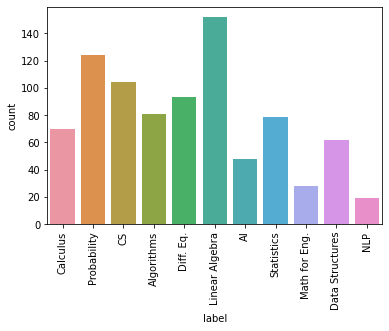

In [6]:
plt.figure()
sns.countplot(x='label', data=data)
plt.xticks(rotation=90)
plt.show()

Отчистим и лемматизируем текст, понизив тем самым размерность признакового пространства

In [7]:
tokenizer = WordPunctTokenizer()
lemmatizer = WordNetLemmatizer()

In [8]:
def clean_data(data):
    cleaned_sent = []
    for sent in data:
        sent = sent.lower() #lower string
        sent = re.sub(r'\d+', '', sent) #remove numbers
        sent = ' '.join([word for word in sent.split() if word not in stopwords.words('english')]) #remove stop words
        sent = ' '.join(tokenizer.tokenize(sent)) #tokenize
        sent = re.sub(r'[^\w\s]','',sent) #remove punctuation
        sent = ' '.join([lemmatizer.lemmatize(word) for word in sent.split()]) #lemmatize words
        cleaned_sent.append(sent)
    return cleaned_sent

Отчистим текст

In [9]:
text = clean_data(data['text'].values)

In [10]:
data['cleaned_text'] = text

Подготвим значения целевого признака

In [16]:
def prep_targets(name):
    if name == 'Calculus':
        return 0
    elif name == 'Probability':
        return 1
    elif name == 'CS':
        return 2
    elif name == 'Algorithms':
        return 3
    elif name == 'Diff. Eq.':
        return 4
    elif name == 'Linear Algebra':
        return 5
    elif name == 'AI':
        return 6
    elif name == 'Statistics':
        return 7
    elif name == 'Math for Eng.':
        return 8
    elif name == 'Data Structures':
        return 9
    else:
        return 10

In [17]:
data['targets'] = data['label'].apply(lambda x: prep_targets(x))

В выборке содержатся 860 текстов. Если сделать каждый текст одним объектом, то объектов будет не хватать, так как необходимое количество данных будет расти экспоненциально с ростом размерности. Разобъем каждый текст на отрывки длинной в 200 слов, каждый из которых будет иметь один и тот же label, соответствующий данному тексту. На инференсе будем также разбивать текст на отрывки, делать для них предсказания, а для всего текста выбирать наиболее часто встречающийся класс среди всех отрывков.

In [19]:
mean_length = np.mean([len(text.split()) for text in data['cleaned_text'].values])
mean_length

2857.0058139534885

In [20]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [25]:
def prep_labels(label):
    if label == 0:
        return 'Calculus'
    elif label == 1:
        return 'Probability'
    elif label == 2:
        return 'CS'
    elif label == 3:
        return 'Algorithms'
    elif label == 4:
        return 'Diff. Eq.'
    elif label == 5:
        return 'Linear Algebra'
    elif label == 6:
        return 'AI'
    elif label == 7:
        return 'Statistics'
    elif label == 8:
        return 'Math for Eng.'
    elif label == 9:
        return 'Data Structures'
    else:
        return 'NLP'

Разобъем тексты на отрывки

In [106]:
texts_ext = []
targets_ext = []
labels_ext = []
    
for target, text in zip(data['targets'].values, data['cleaned_text'].values):    
    for part in chunks(text.split(), 200):
        if len(part) == 200:
            texts_ext.append(part)
            targets_ext.append(target)
            labels_ext.append(prep_labels(target))

In [107]:
texts_ext = [' '.join(text) for text in texts_ext]

In [108]:
len(texts_ext), len(targets_ext), len(labels_ext)

(11853, 11853, 11853)

In [109]:
data_ext = pd.DataFrame({'texts': texts_ext, 'targets': targets_ext, 'labels': labels_ext})
data_ext.head()

,texts,targets,labels
0,following content provided creative common lic...,0,Calculus
1,exactly like polynomial there s one thing care...,0,Calculus
2,think one example i ll repeat example power se...,0,Calculus
3,power series say radius convergence is now tel...,0,Calculus
4,so let s new example now oh way say calculate ...,0,Calculus


Посмотрим на распределение значений целевого признака в расширенном датасете

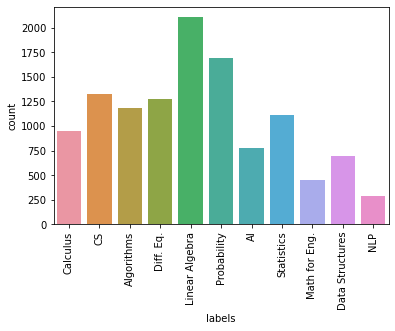

In [110]:
plt.figure()
sns.countplot(x='labels', data=data_ext)
plt.xticks(rotation=90)
plt.show()

Применим positive sampling к AI, Math for Eng., NLP и negative sampling к Probability и Linear Algebra, чтобы алгоритм настраивался на все классы в равной степени

In [111]:
multipliers = {'AI': 0.5, 'Math for Eng.': 1.5, 'Data Structures': 0.4, 'NLP': 3, 'Calculus': 0.2}

In [112]:
for label, multiplier in multipliers.items():
    data_size = data_ext[data_ext['labels'] == label].shape[0]
    index = data_ext[data_ext['labels'] == label].index
    
    size_to_add = int(multiplier * data_size)
    index = np.random.choice(index, size_to_add)
    data_ext = pd.concat([data_ext, data_ext.loc[index, :]])

In [113]:
data_ext.reset_index(drop=True, inplace=True)

Применим negative sampling к 'Linear Algebra', 'Probability'

In [114]:
for label in ['Linear Algebra', 'Probability']:
    num_inst_del = data_ext[data_ext['labels'] == label].shape[0] - data_ext[data_ext['labels'] == 
                                                                             'Algorithms'].shape[0]
    index = data_ext[data_ext['labels'] == label].index
    index = np.random.choice(index, num_inst_del, replace=False)
    data_ext.drop(index, axis=0, inplace=True)

In [115]:
data_ext.reset_index(drop=True, inplace=True)

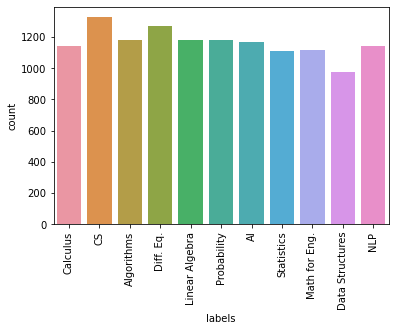

In [116]:
plt.figure()
sns.countplot(x='labels', data=data_ext)
plt.xticks(rotation=90)
plt.show()

Подготовим numpy массивы для текста и значений целевой переменной

In [117]:
features = data_ext['texts'].values
targets = data_ext['targets'].values

In [118]:
features.shape, targets.shape

((12798,), (12798,))

Разделим выборку на тренировочный и тестовый набор

In [119]:
data_train, data_test, targets_train, targets_test = train_test_split(features, targets, test_size=0.1)

In [120]:
data_train.shape, data_test.shape, targets_train.shape, targets_test.shape

((11518,), (1280,), (11518,), (1280,))

Понизим размерность при помощи TSNE для визуализации. Видим, что выборка линейна неразделима.

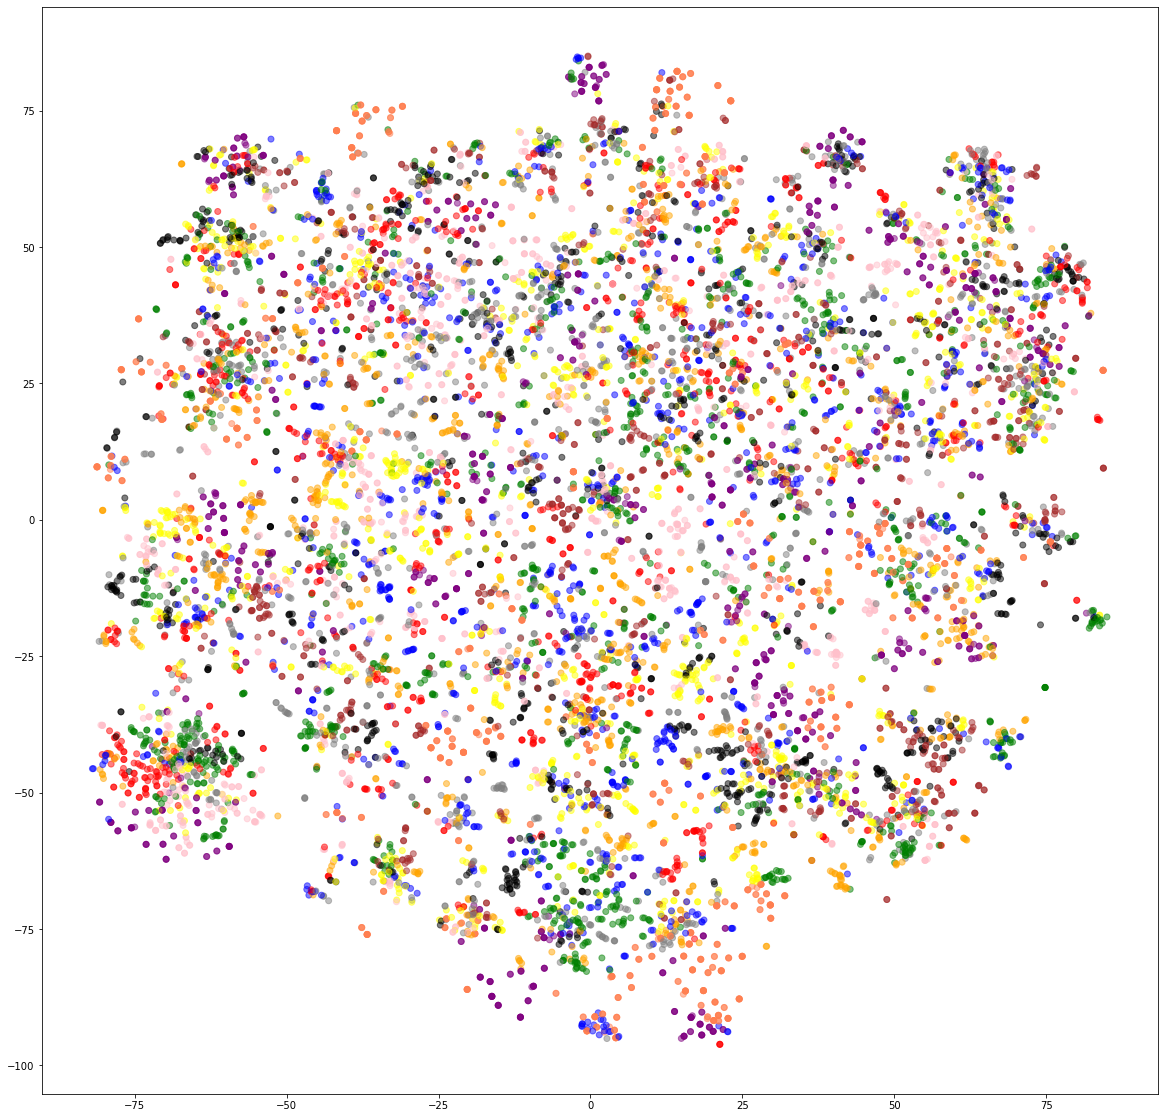

In [286]:
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap

vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 3), min_df=0.05, max_df=0.5)
data_t = vectorizer.fit_transform(data_train)
data_t = TSNE().fit_transform(data_t)
colors = ListedColormap(['red', 'blue', 'green', 'yellow', 'orange', 'grey', 'pink', 'black', 'purple',
                        'brown', 'coral'])
plt.figure(figsize = (20 , 20))
plt.scatter(list(data_t[:, 0]), list(data_t[:, 1]), c=targets_train, cmap=colors, alpha=0.5)
plt.show()

Класс для Pipeline для трансформации матрицы объекты признаки в dense формат (нужен для PCA)

In [121]:
from sklearn.base import BaseEstimator, TransformerMixin

class ToDenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        return csr_matrix(X).todense()

SVC - строго бинарный классификатор, поэтому импользуемая стратегия тренировки в случае мультиклассовости - OVO. Гиперпараметры регуляризации (такие как C) подбирались вручную без использования сетки из-за ограниченных вычислительных ресурсов. Используем rbf кернел для линейно-неразделимой выборки

In [280]:
classifier = Pipeline([
('vectorizer', TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 3), min_df=0.05, max_df=0.5)),
('denser', ToDenseTransformer()),
('reductor', PCA(n_components=0.90)),
('classifier', SVC(kernel='rbf', C=8))])

Проверим качество по кросс-валидации

In [241]:
cross_val_score(classifier, data_train, targets_train, scoring='accuracy', cv=3)

array([0.6203125 , 0.6217765 , 0.61604585])

Построим confusion matrix при помощи cross_val_predict

In [242]:
y_pred = cross_val_predict(classifier, data_train, targets_train, cv=3)
conf_mx = confusion_matrix(targets_train, y_pred)
conf_mx

array([[644,  46,  48,  42,  74,  65,  38,  40,   5,  23,   4],
       [ 65, 502,  99,  79, 103,  88,  38,  63,   7,  28,   6],
       [ 45,  93, 705,  54,  85,  86,  39,  50,  18,  36,   7],
       [ 49,  82,  69, 555,  83,  68,  43,  57,  13,  23,   8],
       [ 65,  98,  74,  69, 651,  86,  27,  38,  16,  35,  12],
       [ 68, 102,  99,  88,  84, 440,  40,  70,  12,  41,  15],
       [ 42,  43,  33,  36,  35,  56, 738,  25,   7,  15,   5],
       [ 51,  72,  67,  58,  70,  82,  31, 522,  14,  21,   3],
       [  7,  22,  18,  17,  18,  18,   9,  14, 870,   5,   2],
       [ 24,  66,  38,  32,  60,  50,  15,  40,   9, 537,   4],
       [  2,   8,  14,   3,   9,   0,   0,   2,   3,   1, 970]])

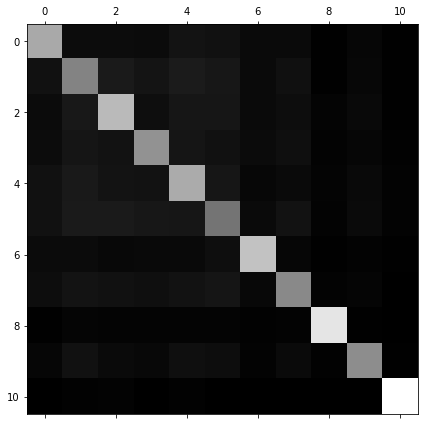

In [289]:
plt.figure(figsize = (7 , 7))
plt.matshow(conf_mx, cmap=plt.cm.gray, fignum=1)
plt.show()

Посмотрим на частоты ошибок по классам

In [244]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

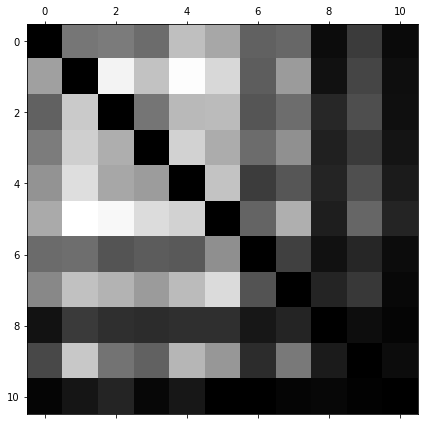

In [290]:
plt.figure(figsize = (7 , 7))
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray, fignum=1)
plt.show()

Затренируем алгоритм на всех данных

In [246]:
classifier.fit(data_train, targets_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char_wb', max_df=0.5, min_df=0.05,
                                 ngram_range=(2, 3))),
                ('denser', ToDenseTransformer()),
                ('reductor', PCA(n_components=0.9)), ('classifier', SVC(C=8))])

Качество на тестовой выборке

In [247]:
accuracy_score(targets_test, classifier.predict(data_test))

0.70078125

Проверим качество на текстах на тестовой выборке, вместо отрывков текста

In [248]:
texts = data['cleaned_text'].values[-80:]
targs = data['targets'].values[-80:]

In [249]:
def predict_text(texts):
    preds_all_texts = []
    for text in texts:
        pred_data = np.array([' '.join(part) for part in chunks(text.split(), 200)])
        preds = classifier.predict(pred_data)
        counts = np.bincount(preds)
        preds_all_texts.append(np.argmax(counts))
    return np.array(preds_all_texts)

In [250]:
preds = predict_text(texts)
preds

array([ 7,  4,  0,  5,  4,  3,  2,  0,  0,  9,  1,  1,  1,  4,  5,  6, 10,
        0,  1,  5,  4,  1,  5,  4,  5,  5,  5,  8,  7,  4,  9,  1,  4,  9,
        2,  1,  2,  3,  3,  0,  1,  2,  0,  7,  1,  9,  3,  4,  7,  2,  0,
        8,  1,  2,  4,  9,  7,  2,  7,  7,  1,  7,  5,  2,  4,  3,  0,  2,
        2,  8,  3,  0,  5,  2,  5,  8,  4,  5,  6,  4])

In [251]:
targs

array([ 7,  4,  0,  5,  4,  3,  2,  0,  0,  9,  1,  1,  1,  4,  5,  6, 10,
        2,  1,  5,  4,  1,  5,  4,  5,  5,  5,  8,  7,  4,  9,  1,  4,  9,
        2,  1,  2,  3,  3,  0,  1,  3,  7,  0,  1,  9,  3,  4,  7,  2,  0,
        8,  1,  2,  4,  9,  7,  2,  7,  7,  1,  7,  5,  2,  4,  3,  0,  2,
        2,  8,  3,  0,  5,  2,  5,  8,  4,  5,  6,  4])

In [253]:
print('Доля правильных ответов на текстах на тестовом наборе: {}'.format(accuracy_score(targs, preds)))

Доля правильных ответов на текстах на тестовом наборе: 0.95


Сохраним классификатор

In [254]:
dump(classifier, '/Users/artyomkholodkov/Downloads/Models/model.pkl', compress=1)

['/Users/artyomkholodkov/Downloads/Models/model.pkl']